## Cleaning and preprocessing of raw data

In [317]:

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout

import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd
import os

# Define the resampling method to be used Resampling method. Choose from 'SMOTE', 'ADASYN', 'RandomUnderSampler',
            #   'RandomOverSampler', 'SMOTEENN', or 'SMOTETomek'.
resampling_method = 'SMOTE'


# Initialize dictionaries to hold the DataFrames
hotel_dfs = {}
input_data_dfs = {}

# Load hotel_dfs from CSV files
hotel_data_dir = 'data_pre/hotel_data'
for filename in os.listdir(hotel_data_dir):
    if filename.endswith('_hotel_data.csv'):
        hotel_name = filename.replace('_hotel_data.csv', '')
        hotel_dfs[hotel_name] = pd.read_csv(os.path.join(hotel_data_dir, filename))

# Load input_data_dfs from CSV files
input_data_dir = 'data_pre/input_data'
for filename in os.listdir(input_data_dir):
    if filename.endswith('_input_data.csv'):
        hotel_name = filename.replace('_input_data.csv', '')
        input_data_dfs[hotel_name] = pd.read_csv(os.path.join(input_data_dir, filename))

print("Hotel data and input data loaded successfully.")

Hotel data and input data loaded successfully.


In [318]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Initialize combined lists
combined_X_train = []
combined_y_train = []
# Initialize combined test lists

raw_train_data = {}
raw_test_data = {}



for hotel_name, df in input_data_dfs.items():
    # Split the dataset into training and testing sets
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        df['cleaned_content'], 
        df['label'], 
        test_size=0.3,
        stratify=df['label'], 
        random_state=42
    )
    
    # Store raw train/test data
    raw_train_data[hotel_name] = (X_train_raw, y_train)
    raw_test_data[hotel_name] = (X_test_raw, y_test)

    # Add to combined lists
    combined_X_train.extend(X_train_raw)  # Use extend to flatten the list for strings
    combined_y_train.extend(y_train.tolist())  # Ensure y_train is a list to extend it

In [319]:
def prepare_data(combined_X_train, combined_y_train, raw_test_data, num_words=5000, maxlen=75):
    tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(combined_X_train)

    X_train_sequences = tokenizer.texts_to_sequences(combined_X_train)
    X_test_sequences = [tokenizer.texts_to_sequences(test_data) for _, (test_data, _) in raw_test_data.items()]

    X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen)
    X_test_padded = [pad_sequences(sequences, maxlen=maxlen) for sequences in X_test_sequences]

    X_train_padded, combined_y_train = shuffle(X_train_padded, combined_y_train, random_state=42)

    train_data = (X_train_padded, np.array(combined_y_train))
    test_data = {hotel_name: (X_test_padded[i], raw_test_data[hotel_name][1]) for i, hotel_name in enumerate(raw_test_data.keys())}

    return train_data, test_data, tokenizer

In [320]:
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

# Define a function to choose the resampling method
def resample_data(X_train, y_train, method='SMOTE'):
    """
    Resample the dataset using the chosen method.

    Parameters:
    - X_train: Features of the training set.
    - y_train: Labels of the training set.
    - method: Resampling method. Choose from 'SMOTE', 'ADASYN', 'RandomUnderSampler',
              'RandomOverSampler', 'SMOTEENN', or 'SMOTETomek'.
    
    Returns:
    - Resampled X_train and y_train.
    """
    
    # Select resampling method
    if method == 'SMOTE':
        resampler = SMOTE(random_state=42)
    elif method == 'ADASYN':
        resampler = ADASYN(random_state=42)
    elif method == 'RandomUnderSampler':
        resampler = RandomUnderSampler(random_state=42)
    elif method == 'RandomOverSampler':
        resampler = RandomOverSampler(random_state=42)
    elif method == 'SMOTEENN':
        resampler = SMOTEENN(random_state=42)
    elif method == 'SMOTETomek':
        resampler = SMOTETomek(random_state=42)
    else:
        print("Unknown resampling method. Choose 'SMOTE', 'ADASYN', 'RandomUnderSampler', 'RandomOverSampler', 'SMOTEENN', or 'SMOTETomek'. Returning unsampled data")
        return X_train, y_train
    
    # Perform resampling
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)
    print(f"Resampled dataset shape y: {Counter(y_resampled)}")
    print(f"Resampled dataset shape X: {len(X_resampled)}")
    
    return X_resampled, y_resampled


In [321]:
import kerastuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import pickle

# Build Model Function
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=5000,
                  output_dim=hp.Int('output_dim', min_value=64, max_value=256, step=64)),
        Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32), kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=True)),
        Bidirectional(LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32))),
        Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu'),
        Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

train_data, test_data, tokenizer = prepare_data(combined_X_train, combined_y_train, raw_test_data)
X_train_padded, y_train = train_data

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_padded, 
    y_train, 
    test_size=0.2, 
    stratify=y_train, 
    random_state=42
)

# Optionally apply resampling
X_train, y_train = resample_data(X_train, y_train, method=resampling_method)
# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='text_classification'
)

stop_early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[stop_early])

# Retrieve and save best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
with open('hyperparameter_tuning/best_hyperparameters.pkl', 'wb') as f:
    pickle.dump(best_hps.values, f)

# Build and train the best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[stop_early])

# Save the training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(f'{resampling_method}hyperparameter_tuning/training_history.csv', index=False)

print("Training and hyperparameter tuning completed successfully.")



Resampled dataset shape y: Counter({2: 3611, 1: 3611, 0: 3611})
Resampled dataset shape X: 10833
Reloading Tuner from my_dir\text_classification\tuner0.json
Epoch 1/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - accuracy: 0.5898 - loss: 0.8075 - val_accuracy: 0.6699 - val_loss: 1.0287
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9254 - loss: 0.2250 - val_accuracy: 0.8127 - val_loss: 0.7680
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9731 - loss: 0.0862 - val_accuracy: 0.8180 - val_loss: 0.9811
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9906 - loss: 0.0391 - val_accuracy: 0.8207 - val_loss: 1.1017
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9932 - loss: 0.0233 - val_accuracy: 0.8064 - val_loss: 1.1567
Training and hyperparameter tuning completed successfully.


Test Accuracy for bai_hotel: 0.8787
Test Loss for bai_hotel: 0.4680
Test Accuracy for dusit_thani_mactan: 0.7870
Test Loss for dusit_thani_mactan: 0.9560
Test Accuracy for fairfield_by_marriott_cebu: 0.7692
Test Loss for fairfield_by_marriott_cebu: 1.1827
Test Accuracy for jpark_island_resort_and_waterpark: 0.6772
Test Loss for jpark_island_resort_and_waterpark: 1.2424
Test Accuracy for seda_ayala_center_cebu: 0.8237
Test Loss for seda_ayala_center_cebu: 0.6994
Test Accuracy for waterfront_hotel_and_casino: 0.6694
Test Loss for waterfront_hotel_and_casino: 1.2411


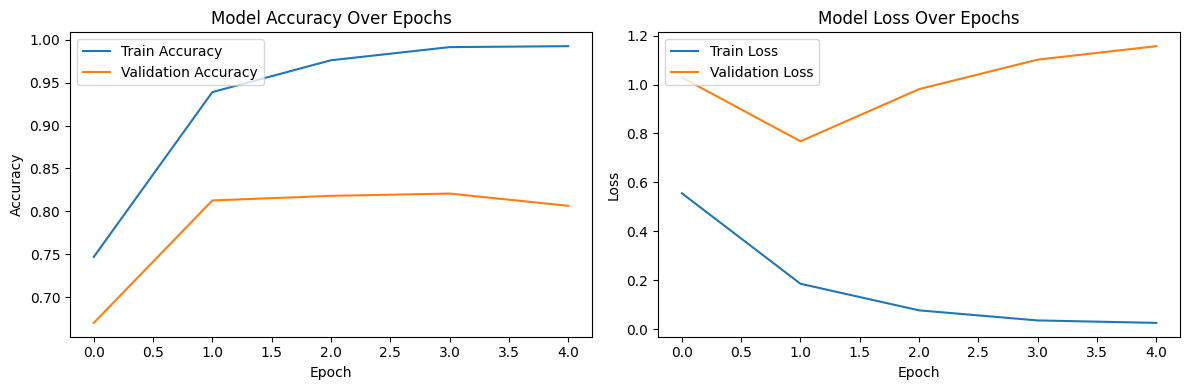

In [322]:
import matplotlib.pyplot as plt


# Function to evaluate the model on test data for multiple hotels
def evaluate_model(model, test_data):
    results = {}
    for hotel_name, (X_test, y_test) in test_data.items():
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        results[hotel_name] = {'accuracy': accuracy, 'loss': loss}
        print(f'Test Accuracy for {hotel_name}: {accuracy:.4f}')
        print(f'Test Loss for {hotel_name}: {loss:.4f}')
    return results

# Function to plot training & validation accuracy and loss values
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Evaluate model
results = evaluate_model(model, test_data)

# Plot training history
plot_training_history(history)


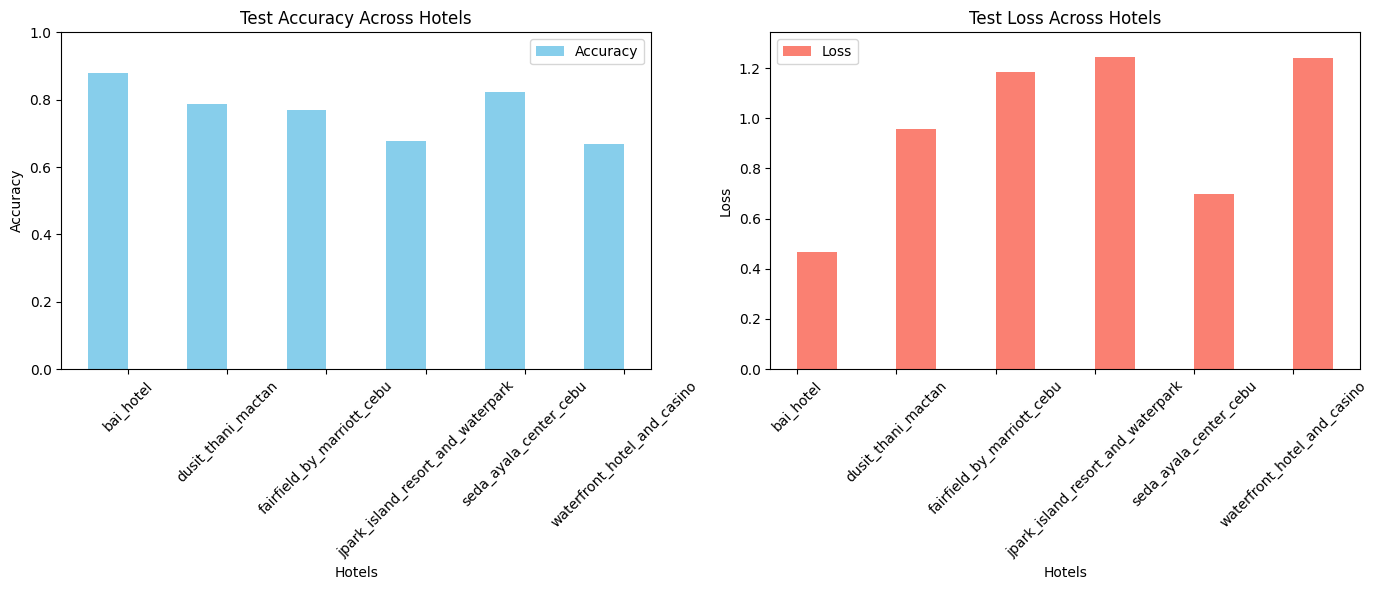

In [323]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot accuracy and loss for each hotel
def plot_accuracy_and_loss(results):
    # Extract hotel names, accuracies, and losses from the results dictionary
    hotels = list(results.keys())
    accuracy = [results[hotel]['accuracy'] for hotel in hotels]
    loss = [results[hotel]['loss'] for hotel in hotels]

    # Create an array for the x-axis labels
    x = np.arange(len(hotels))  # the label locations

    # Set up the figure
    plt.figure(figsize=(14, 6))

    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.bar(x - 0.2, accuracy, 0.4, label='Accuracy', color='skyblue')
    plt.xticks(x, hotels, rotation=45)
    plt.ylim(0, 1)  # Set y-axis limits for accuracy
    plt.xlabel('Hotels')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy Across Hotels')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.bar(x + 0.2, loss, 0.4, label='Loss', color='salmon')
    plt.xticks(x, hotels, rotation=45)
    plt.ylim(0, max(loss) + 0.1)  # Adjust the y-axis limit for loss
    plt.xlabel('Hotels')
    plt.ylabel('Loss')
    plt.title('Test Loss Across Hotels')
    plt.legend()

    # Adjust layout for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_accuracy_and_loss(results)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


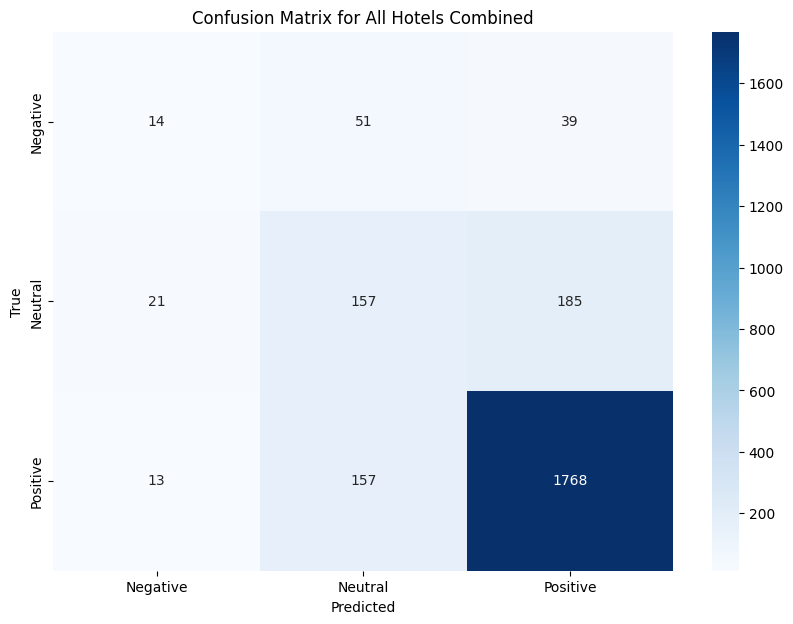

In [324]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Function to downsample test data
def downsample_test_data(test_data):
    downsampled_test_data = {}
    for hotel_name, (X_test, y_test) in test_data.items():
        rus = RandomUnderSampler(random_state=42)
        X_test_resampled, y_test_resampled = rus.fit_resample(X_test, y_test)
        downsampled_test_data[hotel_name] = (X_test_resampled, y_test_resampled)
    return downsampled_test_data


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Function to generate and plot confusion matrices
def plot_confusion_matrices(model, test_data, mode='both', downsample=False):
    """
    Plot confusion matrices for each hotel or combined.
    
    Parameters:
    - model: Trained model used to make predictions.
    - test_data: Dictionary of test data (X_test, y_test) for each hotel.
    - mode: 'individual', 'combined', or 'both' to control output.
    - downsample: Whether to downsample the test data for class balancing.
    """
    if downsample:
        test_data = downsample_test_data(test_data)

    all_y_true = []
    all_y_pred = []

    # Individual confusion matrices
    if mode in ['individual', 'both']:
        for hotel_name, (X_test, y_test) in test_data.items():
            y_pred = model.predict(X_test)
            y_pred_classes = np.argmax(y_pred, axis=1)
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred_classes)
            
            label_counts = Counter(y_test)
            print(f"Label distribution for {hotel_name}: {label_counts}")

            # Generate confusion matrix for individual hotel
            cm = confusion_matrix(y_test, y_pred_classes)
            plt.figure(figsize=(10, 7))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Negative', 'Neutral', 'Positive'], 
                        yticklabels=['Negative', 'Neutral', 'Positive'])
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix for {hotel_name}')
            plt.show()

    # Combined confusion matrix
    if mode in ['combined', 'both']:
        if mode == 'combined':  # If only combined, we need to collect y_true and y_pred
            for hotel_name, (X_test, y_test) in test_data.items():
                y_pred = model.predict(X_test)
                y_pred_classes = np.argmax(y_pred, axis=1)
                all_y_true.extend(y_test)
                all_y_pred.extend(y_pred_classes)

        cm_combined = confusion_matrix(all_y_true, all_y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Negative', 'Neutral', 'Positive'], 
                    yticklabels=['Negative', 'Neutral', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for All Hotels Combined')
        plt.show()
    
plot_confusion_matrices(model, test_data, 'combined')  # Or use downsampled_test_data



In [325]:
from sklearn.metrics import classification_report
import numpy as np

# Function to generate and save classification reports
def classification_reports(model, test_data, mode='both', save_path='classification_report.txt'):
    """
    Generate classification reports for individual hotels and/or a combined report, 
    and print to the console as well as save to a file.
    
    Parameters:
    - model: Trained model used to make predictions.
    - test_data: Dictionary of test data (X_test, y_test) for each hotel.
    - mode: 'individual', 'combined', or 'both' to control output.
    - save_path: Path to save the classification report.
    """
    all_y_true = []
    all_y_pred = []
    
    with open(save_path, 'w') as f:
        # Individual classification reports
        if mode in ['individual', 'both']:
            for hotel_name, (X_test, y_test) in test_data.items():
                # Make predictions
                y_pred = model.predict(X_test)
                y_pred_classes = np.argmax(y_pred, axis=1)
                
                # Collect true and predicted values for combined report if needed
                if mode == 'both' or mode == 'combined':
                    all_y_true.extend(y_test)
                    all_y_pred.extend(y_pred_classes)
                
                # Generate classification report for individual hotel
                report = classification_report(y_test, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive'])
                
                # Print and save individual report to the file
                print(f'Classification Report for {hotel_name}:')
                print(report)
                print('-' * 50)
                
                f.write(f'Classification Report for {hotel_name}:\n')
                f.write(report + '\n')
                f.write('-' * 50 + '\n')
        
        # Combined classification report
        if mode in ['combined', 'both']:
            # If mode is only 'combined', collect predictions across all hotels
            if mode == 'combined':
                for hotel_name, (X_test, y_test) in test_data.items():
                    y_pred = model.predict(X_test)
                    y_pred_classes = np.argmax(y_pred, axis=1)
                    all_y_true.extend(y_test)
                    all_y_pred.extend(y_pred_classes)
            
            # Generate combined classification report
            combined_report = classification_report(all_y_true, all_y_pred, target_names=['Negative', 'Neutral', 'Positive'])
            
            # Print and save combined report
            print('Classification Report for All Hotels Combined:')
            print(combined_report)
            
            f.write('Classification Report for All Hotels Combined:\n')
            f.write(combined_report + '\n')

    print(f'Classification report(s) saved to {save_path}')

# Usage
classification_reports(model, test_data, mode='combined', save_path=f'classification_reports/{resampling_method}_para_tune_combined.txt')


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Classification Report for All Hotels Combined:
              precision    recall  f1-score   support

    Negative       0.29      0.13      0.18       104
     Neutral       0.43      0.43      0.43       363
    Positive       0.89      0.91      0.90      1938

    accuracy                           0.81      2405
   macro avg       0.54      0.49      0.51      2405
weighted avg       0.79      0.81      0.80      2405

Classification report(s) saved to classification_reports/RandomOverSampler_para_tune_combined.txt


In [326]:
# # Count the number of cleaned reviews per hotel
# cleaned_reviews_count = {hotel: df['cleaned_content'].notnull().sum() for hotel, df in hotel_dfs.items()}

# # Print the counts
# for hotel, count in cleaned_reviews_count.items():
#     print(f"{hotel}: {count} cleaned reviews")

In [327]:
# import os
# import pandas as pd
# import numpy as np

# output_dir = 'predictions_by_hotel'
# os.makedirs(output_dir, exist_ok=True)

# for hotel_name, (X_test, y_test) in test_data.items():
#     # Evaluate the model
#     loss, accuracy = model.evaluate(X_test, y_test)
#     print(f'Test Accuracy for {hotel_name}: {accuracy:.4f}')
    
#     # Make predictions
#     predicted_scores = model.predict(X_test)  # Predicted scores give probabilities for each class
    
    
    
#     # Convert predicted probabilities to class labels
#     predicted_classes = np.argmax(predicted_scores, axis=1)  # Get index of max probability for each sample
#     # Create a DataFrame to store true labels and predicted labels
#     predictions = {
#         'true_label': y_test,
#         'predicted_class': predicted_classes,
#         'predicted_scores': predicted_scores.tolist()  # Store the original probabilities if needed
#     }
    
#     # Convert to DataFrame
#     predictions_df = pd.DataFrame(predictions)
    
#     # Add hotel name to the DataFrame
#     predictions_df['hotel_name'] = hotel_name
    
#     # Save predictions to a CSV file, named after the hotel
#     predictions_filename = os.path.join(output_dir, f'{hotel_name}_predictions.csv')
#     predictions_df.to_csv(predictions_filename, index=False)

#     print(f'Predictions for {hotel_name} saved to {predictions_filename}')

In [328]:
# from datetime import datetime
# import os

# # Assuming `model` is your Keras model
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# file_name = f'saved_models/General_Sen_{timestamp}.keras'

# # Make sure the directory exists
# os.makedirs(os.path.dirname(file_name), exist_ok=True)

# # Save the model with the unique file name
# model.save(file_name)
# print(f"Model saved as {file_name}")
# model.summary()

In [329]:
import pyttsx3
import winsound

# Sound alert using a predefined beep sound
frequency = 1000  # Set Frequency To 1000 Hertz
duration = 1000   # Set Duration To 3000 ms == 3 seconds

def say_alert(message, speed=150):
    # Initialize the text-to-speech engine
    engine = pyttsx3.init()
    
    # Beep sound alert
    winsound.Beep(frequency, duration)

    # Set properties
    engine.setProperty('rate', speed)  # Speed (higher is faster)
    engine.setProperty('volume', 0.5)     # Volume (0.0 to 1.0)

    # Speak the message
    engine.say(message)

    # Wait for the speech to finish
    engine.runAndWait()

# Call the function with your alert message and desired speed
say_alert("Program has finished running", speed=150)  # Adjust speed as needed


